In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt
import BelleII as b2

class FPGA_parallel_conv2D():
    def __init__(self,
                 filter_param,
                 filter_strides,
                 pool_type,
                 pool_size,
                 pool_strides):
        
        # Conv2D_layer
        self.filter_x          = filter_param.shape[1]
        self.filter_y          = filter_param.shape[0]
        self.filter_param = tf.constant(filter_param.reshape(self.filter_y,self.filter_x,1,1), dtype = tf.float32)
        self.filter_strides = filter_strides
        self.filter_strides_x = filter_strides[2]
        self.filter_strides_y = filter_strides[1]
        # Pool_layer
        self.pool_type = pool_type
        self.pool_size = pool_size
        self.pool_strides = pool_strides
        # get parallel window position for conv2d
        self.window_position_tensor = self._get_window_position()
        self.window_num = self.window_position_tensor.shape[0]

    def _set_conv_filter(self,
                    filter_param,
                    filter_strides):
        
        self.filter_x          = filter_param.shape[1]
        self.filter_y          = filter_param.shape[0]
        self.filter_param = tf.constant(filter_param.reshape(filter_y,filter_x,1,1), dtype = tf.float32)
        self.filter_strides = filter_strides
        
    def _set_pool_layer(self,
                       pool_type,
                       pool_size,
                       pool_strides):
        
        self.pool_type = pool_type
        self.pool_size = pool_size
        self.pool_strides = pool_strides
    
    def forward_calculation(self,
                            x,
                            ):
        x = tf.nn.conv2d(
        x,
        self.filter_param,
        self.filter_strides,
        "VALID")
        if self.pool_type == "max_pool":
            y = tf.nn.max_pool2d(
            x,
            ksize=    self.pool_size,
            strides=  self.pool_strides,
            padding = "VALID")
        elif self.pool_type == "average_pool":
            y = tf.nn.avg_pool2d(
            x,
            ksize=    self.pool_size,
            strides=  self.pool_strides,
            padding = "VALID")
        
        
        return y.numpy()
    
    def trace_conv2d_layer(self,x):
        x = tf.nn.conv2d(
        x,
        self.filter_param,
        self.filter_strides,
        "VALID")
        return x.numpy()
    
    def _get_window_position(self,
                               input_shape_x = 160,
                               input_shape_y = 56
                              ):
        
        window_range_x = (input_shape_x - self.filter_x ) // self.filter_strides_x + 1
        window_range_y = (input_shape_y - self.filter_y ) // self.filter_strides_y + 1
        print(f"filter_y is {self.filter_y}")
        print(f"window_range_X {window_range_x}")
        print(f"window_range_y {window_range_y}")
        window_selection_list = []
        for window_num_y in range(window_range_y):
            for window_num_x in range(window_range_x):
                pixs_in_this_window = []
                anker_x = 0 if window_num_x==0 else window_num_x * self.filter_strides_x - 1
                anker_y = 0 if window_num_y==0 else window_num_y * self.filter_strides_y - 1
                for pos_y_in_this_window in range(anker_y,anker_y + self.filter_y):
                    for pos_x_in_this_window in range(anker_x,anker_x + self.filter_x):
                        pixs_in_this_window.append([pos_x_in_this_window,pos_y_in_this_window])
                window_selection_list.append(pixs_in_this_window)
        return np.array(window_selection_list,dtype = object)
    
    def _write_HDL_window_selecotr(self,
                                   #file_name = "Conv2d_window_selector.v"
                                  ):
        
        verilog_code = ""
        Header = " \n"
        verilog_code += Header
        
        # Generate Wire
        wires = f"wire [{self.filter_x*self.filter_y - 1}:0] to_parallel_conv2d [0:{self.window_num-1}] ; \n"
        verilog_code += wires
        
        # Assign those wires from the pix input line
        assignment = f"assign "
        verilog_code += assignment


        
        
        #with open(file_name,"w") as file:
            #file.write(verilog_code)
        return verilog_code
    
    def _write_HDL_Conv2D(self,
                          file_name = "Conv2d_calculation.v"):
        verilog_code = ""
        # TO DO
        # Add transcompiler logic here
        with open(file_name,"w") as file:
            file.write(verilog_code)
            
    def _create_adder_configuration_matrix(self,
                                           #start_reg_width ,
                                           adder_input_size):
        connection_matrix_per_stage = []               # nd array, indexed by stage
        connection_matrix_first_stage =[i for i in range(self.filter_x * self.filter_y)]
        connection_matrix_per_stage.append(connection_matrix_first_stage)
        
        # calculate the connection_matrix untill the outcome of this stage only takes 1 reg
        process = True
        anker   = 0    # holds the n-th input index from last stage
        stage_in_process = 0
        while(process):
            
            # households for each calculation
            input_size_this_stage = len(connection_matrix_per_stage[stage_in_process])
            connection_matrix_in_this_stage = [] # holds the connection for this stage
            anker = 0
            
            # add nornaml connections in the connections matrix, if exits
            for which_reg in range(input_size_this_stage // adder_input_size): # Loop all valid normal connections
                connection_to_this_reg = []
                for connections in range(adder_input_size*which_reg,adder_input_size*(which_reg + 1)):
                    connection_to_this_reg.append(connections)
                    anker = connections
                connection_matrix_in_this_stage.append(connection_to_this_reg)
                
            # for residual connections
            if(input_size_this_stage % adder_input_size != 0):
                connection_to_this_reg = []
                if(input_size_this_stage < adder_input_size): # if only residual connections in this stage
                    for residual_reg in range(input_size_this_stage % adder_input_size):
                        connection_to_this_reg.append(anker + residual_reg)
                else:
                    for residual_reg in range(input_size_this_stage % adder_input_size):
                        connection_to_this_reg.append(anker + 1 + residual_reg)
                connection_matrix_in_this_stage.append(connection_to_this_reg)
            
            # save the current connection in the matrix
            connection_matrix_per_stage.append(connection_matrix_in_this_stage)
            stage_in_process += 1 
            
            if len(connection_matrix_per_stage[stage_in_process]) == 1:
                print(f"adder tree solution with current setting found! ")
                break
            if stage_in_process >= 99:
                raise ValueError(f"hy fuck you ! adder tree stage passed 99, some setting is wrong!")
            
        return connection_matrix_per_stage
            
    def _write_HDL_adder_tree(self,
                              print_config,
                              out_dir,                  # String: output directory
                              start_reg_width,          # Int   : Reg_width
                              adder_input_size          # Int   : how many parallel input can a single adder take
                             ):
        
        vcode = ""   # String hold the verilog code
        
        # Create the connection matrix
        adder_config = self._create_adder_configuration_matrix(
                                                            #start_reg_width = start_reg_width,
                                                               adder_input_size = adder_input_size)
        if print_config:
            print(adder_config)
            
        # get rid of the input layer
        adder_config = adder_config[1:]
        
        # for stage
        for stage_idx, stage_configuration in enumerate(adder_config):
            
            # Create a Headr for each Stage block
            vcode += f"\n"
            vcode += f"// <<<<---------Stage {stage_idx}--------->>>> \n"
            vcode += f"\n"
            # Generate the corresponding regs for that stage
            vcode += f"reg [{start_reg_width + stage_idx * (adder_input_size - 1)-1}:0] partial_sum_stage_{stage_idx} [{len(adder_config[stage_idx]) - 1}:0];\n"
            vcode += f"\n"
            # Always block
            vcode += f"always@(posedge(clk)) begin\n"
            
            # Loop indexed by connections in a given stage
            for reg_num,connection_array in enumerate(stage_configuration):
                vcode += f"    partial_sum_stage_{stage_idx} [{reg_num}] <="
                for idx,connections in enumerate(connection_array):
                    if stage_idx == 0:
                        vcode = vcode + f" PIX_IN[{connections}]" if idx== 0 else vcode + f" + PIX_IN[{connections}]"
                    else:
                        vcode = vcode + f" partial_sum_stage_{stage_idx - 1}[{connections}]" if idx==0 else vcode + f" + partial_sum_stage_{stage_idx - 1}[{connections}]"
                vcode += f";\n"
            vcode += f"end \n"
            
        print(f"Conversion complet without problem!")
            
        with open(out_dir,"w") as file:
            file.write(vcode)
            

2023-02-23 17:48:05.013389: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 17:48:05.013430: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [33]:
from BelleII import BelleCdcWire as CDCwire

class FPGA_hit_image_converter():
    def __init__(self):
        self.Lining_dict = self._create_Lining_dict()
        
    def _create_Lining_dict(self):
        Push_up_offset = 3
        Pull_down_offset = 3
        Lining_dict = {}
        for wireid in range(14336):
    
            _layer,_wire = CDCwire._calculateLayerWire(wireid)
            _index_from_offset =  _wire
    
            if CDCwire._calculateSuperlayer_from_id(wireid) == 3 :       # Push Up On Superlayer 3       # Max wire 224
            
                if _wire >= Push_up_offset:
                
                    _index_from_offset = _wire - Push_up_offset
                
                else:
                
                    _index_from_offset = 224 - (Push_up_offset - _wire)
            
            elif CDCwire._calculateSuperlayer_from_id(wireid) == 7 :    # Push Up on Superlayer 7     # Max wire 352
            
                if _wire >= Push_up_offset:
                
                    _index_from_offset = _wire - Push_up_offset
                
                else:
                
                    _index_from_offset = 352 - (Push_up_offset - _wire)
                
            elif CDCwire._calculateSuperlayer_from_id(wireid) == 1 :     # Pull down on Superlayer 1   # Max wire 160
                #print("ss")
                if _wire >=  160 - Pull_down_offset:
                
                    _index_from_offset = _wire - (160 - Pull_down_offset) 
                
                else:
                
                    _index_from_offset = _wire + Pull_down_offset
            
                
            elif CDCwire._calculateSuperlayer_from_id(wireid) == 5 :    # Pull down on Superlayer 5    # Max wire 288
            
                if _wire >= 288 - Pull_down_offset:
                
                    _index_from_offset = _wire - (288 - Pull_down_offset)
                
                else:
                
                    _index_from_offset = _wire + Pull_down_offset
             
            Lining_dict[wireid] = (_index_from_offset,_layer)
        return Lining_dict
        
    def OR_Gate_mapping(self,
        index_from_offset, # Int
        layer              # Int
        ):

    
        _super_layer = CDCwire._calculateSuperlayer_from_layer(layer)
        y = layer
    
        if _super_layer == 0:                                                              ####### 0
        
            unsqueezed_bitwidth = 5 
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 1
            elif position_in_segment == 2:
                embedding = 2
            elif position_in_segment == 3:
                embedding = 3
            elif position_in_segment == 4:
                embedding = 4

            x = segment_ID * 5 + embedding
        
        elif _super_layer == 1:                                                         #######  1
            unsqueezed_bitwidth = 5 
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 1
            elif position_in_segment == 2:
                embedding = 2
            elif position_in_segment == 3:
                embedding = 3
            elif position_in_segment == 4:
                embedding = 4

            x = segment_ID * 5 + embedding
            x =  index_from_offset
        elif _super_layer == 2:
        
            unsqueezed_bitwidth = 6 
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 1
            elif position_in_segment == 2:
                embedding = 2
            elif position_in_segment == 3:
                embedding = 2
            elif position_in_segment == 4:
                embedding = 3
            elif position_in_segment == 5:
                embedding = 4
            x = segment_ID * 5 + embedding
        
        elif _super_layer == 3:
        
            unsqueezed_bitwidth = 7
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 1
            elif position_in_segment == 2:
                embedding = 1
            elif position_in_segment == 3:
                embedding = 2
            elif position_in_segment == 4:
                embedding = 3
            elif position_in_segment == 5:
                embedding = 4
            elif position_in_segment == 6:
                embedding = 4
            x = segment_ID * 5 + embedding
        
        elif _super_layer == 4:
            unsqueezed_bitwidth = 8
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 0
            elif position_in_segment == 2:
                embedding = 1
            elif position_in_segment == 3:
                embedding = 2
            elif position_in_segment == 4:
                embedding = 2
            elif position_in_segment == 5:
                embedding = 3
            elif position_in_segment == 6:
                embedding = 4
            elif position_in_segment == 7:
                embedding = 4
            
            x = segment_ID * 5 + embedding
        
        elif _super_layer == 5:
            unsqueezed_bitwidth = 9
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 0
            elif position_in_segment == 2:
                embedding = 1
            elif position_in_segment == 3:
                embedding = 1
            elif position_in_segment == 4:
                embedding = 2
            elif position_in_segment == 5:
                embedding = 3
            elif position_in_segment == 6:
                embedding = 3
            elif position_in_segment == 7:
                embedding = 4
            elif position_in_segment == 8:
                embedding = 4
            x = segment_ID * 5 + embedding
        
        elif _super_layer == 6:
            unsqueezed_bitwidth = 10
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 0
            elif position_in_segment == 2:
                embedding = 1
            elif position_in_segment == 3:
                embedding = 1
            elif position_in_segment == 4:
                embedding = 2
            elif position_in_segment == 5:
                embedding = 2
            elif position_in_segment == 6:
                embedding = 3
            elif position_in_segment == 7:
                embedding = 3
            elif position_in_segment == 8:
                embedding = 4
            elif position_in_segment == 9:
                embedding = 4
            
            x = segment_ID * 5 + embedding
        
        elif _super_layer == 7:
            unsqueezed_bitwidth = 11
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 0
            elif position_in_segment == 2:
                embedding = 1
            elif position_in_segment == 3:
                embedding = 1
            elif position_in_segment == 4:
                embedding = 2
            elif position_in_segment == 5:
                embedding = 2
            elif position_in_segment == 6:
                embedding = 2
            elif position_in_segment == 7:
                embedding = 3
            elif position_in_segment == 8:
                embedding = 3
            elif position_in_segment == 9:
                embedding = 4
            elif position_in_segment == 10:
                embedding = 4
            
            x = segment_ID * 5 + embedding
        
        
        elif _super_layer == 8:
        
            unsqueezed_bitwidth = 12
            segment_ID = int(index_from_offset / unsqueezed_bitwidth)
            position_in_segment = index_from_offset % unsqueezed_bitwidth
        
            if position_in_segment == 0:
                embedding = 0
            elif position_in_segment == 1:
                embedding = 0
            elif position_in_segment == 2:
                embedding = 1
            elif position_in_segment == 3:
                embedding = 1
            elif position_in_segment == 4:
                embedding = 1
            elif position_in_segment == 5:
                embedding = 2
            elif position_in_segment == 6:
                embedding = 2
            elif position_in_segment == 7:
                embedding = 3
            elif position_in_segment == 8:
                embedding = 3
            elif position_in_segment == 9:
                embedding = 3
            elif position_in_segment == 10:
                embedding = 4
            elif position_in_segment == 11:
                embedding = 4
            
            x = segment_ID * 5 + embedding
    
        return ( x , y , embedding )
    def convert_one_frame(self,
                         this_frame # defined as 1d array with the size of 14336 
                         ):
        converted_frame = np.zeros(shape=(56,160))
        for wireid in np.where(this_frame == 1)[0]:
            (pix_x,pix_y,_) = self.OR_Gate_mapping(self.Lining_dict[wireid][0],self.Lining_dict[wireid][1])
            converted_frame[pix_y,pix_x] = 1
        return converted_frame

    def convert_frame_batch(self,frame_batch):
        batch_size = frame_batch.shape[0]
        converted_frame_batch = np.zeros(shape=(batch_size,56,160))
        for frame_num in range(batch_size):
            converted_frame_batch[frame_num] = self.convert_one_frame(frame_batch[frame_num])
        return converted_frame_batch
    
    def create_system_verilog(self,out_dir = ""):
        code = ""
        
        # Logic to generate system verilog code
        # ports
        code += "module cdc_hit_image_converter( \n "
        code += " input wire clk,\n"
        code += " input wire cdc_wire [14335:0], \n"
        code += " output wire hit_image_pix[55:0][159:0] \n"
        code += " );\n"
        #regs
        code += "logic cdc_wire_hit_status [14335:0]; \n"
        #syschrous on posedge clk
        code += "always@(posedge(clk)) begin \n"
        code += "     cdc_wire_hit_status <= cdc_wire;\n"
        code += "end \n"
        #rewiring 
        cdc_to_pix_position = []
        for i in range(14336):
            (pix_x,pix_y,_) = self.OR_Gate_mapping(self.Lining_dict[i][0],self.Lining_dict[i][1])
            cdc_to_pix_position.append([pix_x,pix_y])
        print(cdc_to_pix_position)
            
        for pos_y in range(56):
            for pos_x in range(160):
                code += f"assign hit_image_pix[{pos_y}][{pos_x}] = "
                flag = True
                for wire_id in range(14336):
                    if (cdc_to_pix_position[wire_id] == [pos_x,pos_y]) :
                        if flag == True:
                            code += f"cdc_wire_hit_status[{wire_id}]"
                        else:
                            code += f"| cdc_wire_hit_status[{wire_id}]"
                        
                        flag = False
                code +=";\n"
        code += "endmodule"
        with open(out_dir,"w") as file:
            file.write(code)

In [ ]:
temp = FPGA_hit_image_converter()
temp.create_system_verilog(out_dir="image_converter.sv")


## Generate Kernel

In [ ]:
sigma = 2.0
ksize = 9
kernel = np.zeros((ksize, ksize))
def gaussian_kernel_2d(x, y, sigma):
    return np.exp(-(x**2 + y**2) / (2 * sigma**2))
center = np.array(kernel.shape) // 2

for x in range(kernel.shape[0]):
    for y in range(kernel.shape[1]):
        kernel[x, y] = gaussian_kernel_2d(x-center[0], y-center[1], sigma)

# scale the kernel to our maximum precision so we can quantize it. The highest value will always be in the center.
resolution = 2**4  # 8-bit resolution
kernel *= resolution / kernel.max()

# integer quantization
kernel = kernel.astype(np.int32)
print(kernel)

plt.imshow(kernel, cmap='gray')
plt.show()

## Load Dataset

In [4]:
x,y = np.load("/home/updyh/DataSet/master_row_hits.npy"),np.load("/home/updyh/DataSet/master_row_hits_vertex.npy")

## Initialize the FPGA_Hardware for Simulation

filter_y is 9
window_range_X 38
window_range_y 12


2023-02-20 12:46:56.173233: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-20 12:46:56.182417: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-20 12:46:56.211594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 46 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.23GiB/s
2023-02-20 12:46:56.211635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-20 12:46:56.746219: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-20 12:46:56.746319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.1

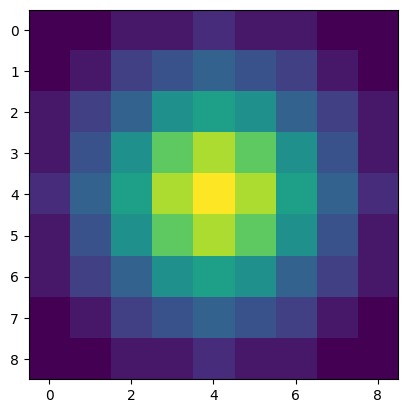

adder tree solution with current setting found! 
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18, 19], [20, 21, 22, 23], [24, 25, 26, 27], [28, 29, 30, 31], [32, 33, 34, 35], [36, 37, 38, 39], [40, 41, 42, 43], [44, 45, 46, 47], [48, 49, 50, 51], [52, 53, 54, 55], [56, 57, 58, 59], [60, 61, 62, 63], [64, 65, 66, 67], [68, 69, 70, 71], [72, 73, 74, 75], [76, 77, 78, 79], [80]], [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18, 19], [20]], [[0, 1, 2, 3], [4, 5]], [[0, 1]]]
Conversion complet without problem!


In [5]:
## Image_Converter
FPGA_image_converter = FPGA_hit_image_converter()

## Fixed Conv2D
fixed_kernel_001 = np.array([
    [1,1,1,1,1,1,1],
    [1,2,2,2,2,2,1],
    [1,2,3,3,3,2,1],
    [1,2,3,4,3,2,1],
    [1,2,3,3,3,2,1],
    [1,2,2,2,2,2,1],
    [1,1,1,1,1,1,1]
])

fixed_kernel_002 = np.array([
    [1,1,1,1,1,1,1],
    [1,0,0,0,0,0,1],
    [1,0,3,3,3,0,1],
    [1,0,3,0,3,0,1],
    [1,0,3,3,3,0,1],
    [1,0,0,0,0,0,1],
    [1,1,1,1,1,1,1]
])
fixed_kernel_003 = kernel

FPGA_fixed_kernel = FPGA_parallel_conv2D(
filter_param   = fixed_kernel_003,
filter_strides = [1,4,4,1], ## Defined as [in channel, strides_y , strides_x , out_channel]
pool_type      = "max_pool",
#pool_type      = "average_pool",    
pool_size      = (2,2),
pool_strides   = (2,2)
)
plt.imshow(fixed_kernel_003)
plt.show()

FPGA_fixed_kernel._write_HDL_adder_tree(out_dir="adder_treev1.v",
                                        start_reg_width=6,
                                        adder_input_size=4,
                                        print_config=True)


In [6]:
HIT_IMAGE_single_channel = np.ones((1,55,160,1))

## CONV_IMAGE
CONVED_IMAGE   =   FPGA_fixed_kernel.trace_conv2d_layer(HIT_IMAGE_single_channel)
print(f"CONVED_IMAGE shape is {CONVED_IMAGE.shape} ")

## Pooled_IMAGE 
POOLED_IMAGE   =   FPGA_fixed_kernel.forward_calculation(HIT_IMAGE_single_channel)
FLATTED_POOLED_IMAGE = POOLED_IMAGE.reshape(POOLED_IMAGE.shape[0],POOLED_IMAGE.shape[1]*POOLED_IMAGE.shape[2])
print(f"POOLED_IMAGE shape is {POOLED_IMAGE.shape} ")
print(f"FLATTED_POOLED_IMAGE shape to Dense Neural Network is {FLATTED_POOLED_IMAGE.shape}")

CONVED_IMAGE shape is (1, 12, 38, 1) 
POOLED_IMAGE shape is (1, 6, 19, 1) 
FLATTED_POOLED_IMAGE shape to Dense Neural Network is (1, 114)


## Forward DataBatch Calculation

In [7]:
## CDCwire 2 HIT image
HIT_IMAGE      =   FPGA_image_converter.convert_frame_batch(x)
print(f"HIT image shape is{HIT_IMAGE.shape}")

## reshape for channels
HIT_IMAGE_single_channel = HIT_IMAGE.reshape(HIT_IMAGE.shape[0],56,160,1)

## CONV_IMAGE
CONVED_IMAGE   =   FPGA_fixed_kernel.trace_conv2d_layer(HIT_IMAGE_single_channel)
print(f"CONVED_IMAGE shape is {CONVED_IMAGE.shape} ")

## Pooled_IMAGE 
POOLED_IMAGE   =   FPGA_fixed_kernel.forward_calculation(HIT_IMAGE_single_channel)
FLATTED_POOLED_IMAGE = POOLED_IMAGE.reshape(POOLED_IMAGE.shape[0],POOLED_IMAGE.shape[1]*POOLED_IMAGE.shape[2])
print(f"POOLED_IMAGE shape is {POOLED_IMAGE.shape} ")
print(f"FLATTED_POOLED_IMAGE shape to Dense Neural Network is {FLATTED_POOLED_IMAGE.shape}")

HIT image shape is(45484, 56, 160)


2023-02-20 12:47:07.651199: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1630146560 exceeds 10% of free system memory.


CONVED_IMAGE shape is (45484, 12, 38, 1) 


2023-02-20 12:47:10.337377: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1630146560 exceeds 10% of free system memory.


POOLED_IMAGE shape is (45484, 6, 19, 1) 
FLATTED_POOLED_IMAGE shape to Dense Neural Network is (45484, 114)


In [ ]:

np.save("pooled_images_x.npy",FLATTED_POOLED_IMAGE)

## Plot the shit

Total 45484 events are found in the Dataset


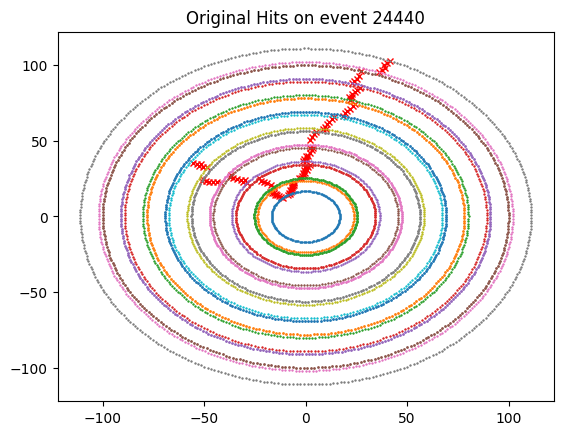

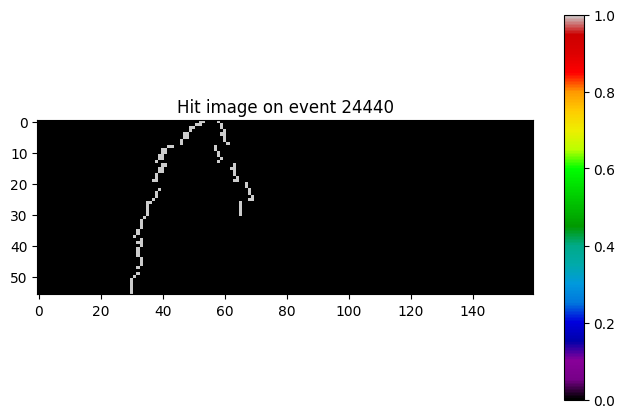

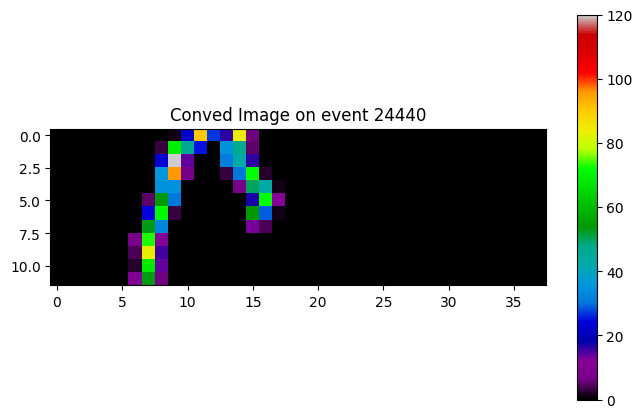

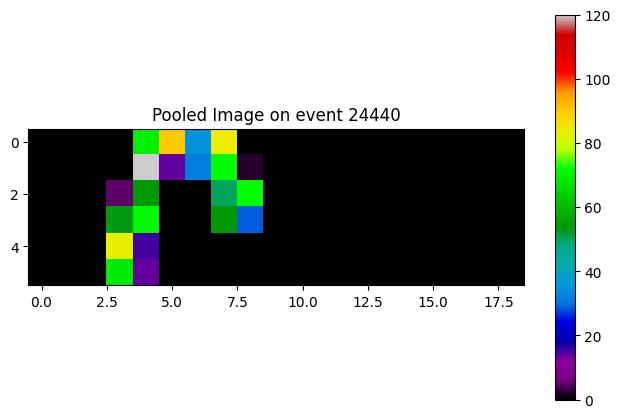

In [14]:
print(f"Total {x.shape[0]} events are found in the Dataset")
eventid = np.random.randint(0,x.shape[0])

## PLOT Original hits
plt.title(f"Original Hits on event {eventid}")
b2._plot_mark_from_wireid(np.where(x[eventid] == 1)[0])
b2._plot_cross_section_edge()
plt.show()

## PLOT HIT image 

fig, ax = plt.subplots(figsize=(8,5))
plt.title(f"Hit image on event {eventid}")

im = ax.imshow(HIT_IMAGE[eventid], cmap='nipy_spectral')
cb = fig.colorbar(im, ax=ax)
#plt.title(f"Hit image on event {eventid}")
#plt.imshow(HIT_IMAGE[eventid])
plt.show()

## PLOT CONVED image
fig, ax = plt.subplots(figsize=(8,5))
plt.title(f"Conved Image on event {eventid}")
im = ax.imshow(CONVED_IMAGE[eventid].reshape(CONVED_IMAGE.shape[1],CONVED_IMAGE.shape[2]), cmap='nipy_spectral')
cb = fig.colorbar(im, ax=ax)
#plt.title(f"Conved Image on event {eventid}")
#plt.imshow(CONVED_IMAGE[eventid].reshape(CONVED_IMAGE.shape[1],CONVED_IMAGE.shape[2]))
plt.show()

## PLOT POLLED image

fig, ax = plt.subplots(figsize=(8,5))
plt.title(f"Pooled Image on event {eventid}")
im = ax.imshow(POOLED_IMAGE[eventid].reshape(POOLED_IMAGE.shape[1],POOLED_IMAGE.shape[2]), cmap='nipy_spectral')
cb = fig.colorbar(im, ax=ax)

#plt.title(f"Pooled Image on event {eventid}")
#plt.imshow(POOLED_IMAGE[eventid].reshape(POOLED_IMAGE.shape[1],POOLED_IMAGE.shape[2]))
plt.show()

In [9]:
np.save()

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [10]:
import math
def create_HDL_adder_tree(
                            input_size =     49, # 1 bit black/write input for each window
                            start_reg_size = 6,   # stage 0 reg size
                            adder_input_size = 2
):
        
        # Variables to hold the partial_sum REG configuration
        reg_size_for_each_stage  = []  # List indexed by stage 
        residul_to_next_stage    = []  # List indexed by stage 
        
        # start process
        stage = 0
        process = True
        while(process):
            reg_size = input_size // adder_input_size   if stage == 0 else (reg_size_for_each_stage[stage - 1] + residul_to_next_stage[stage - 1]) // adder_input_size
            residul_reg = input_size % adder_input_size if stage == 0 else (reg_size_for_each_stage[stage - 1] + residul_to_next_stage[stage - 1]) % adder_input_size
            
            reg_size_for_each_stage.append(reg_size)
            residul_to_next_stage.append(residul_reg)
            stage += 1
            if(reg_size == 1 and residul_reg == 0):
                break
            
            if stage >= 99:
                print("fuck you, something is wrong")
                break
        
        # calculate necessary reg width for each stage to prevent overflow
        reg_width_for_each_stage = [start_reg_size + i for i in range(len(reg_size_for_each_stage))]
        print(f"----partial sum Reg width Configutaion for each stage----")
        print(f"{reg_width_for_each_stage}")
        print(f"----partial sum Reg Configutaion for each stage----")   
        print(reg_size_for_each_stage)
        print(f"----Residual Regs to next stage----")
        print(residul_to_next_stage)
        
        ## Verilog code generation logic
        
        verilog_code = ""        
        verilog_code += "// this piece of code is auto generated by script \n"
        
        residual_flag = False
        
        for stage_idx,reg_size in enumerate(reg_size_for_each_stage):
            
            # give a heder for each stage 
            verilog_code += f"// Stage:{stage_idx} Block \n\n"
            
            # generate Nornal regs for this stage
            verilog_code += f"reg [{reg_width_for_each_stage[stage_idx] - 1}:0] partial_sum_reg_stage_{stage_idx} [{reg_size_for_each_stage[stage_idx] - 1}:0] \n"
            
            # generate residual regs for this stage
            if(residul_to_next_stage[stage_idx] != 0):
                residual_flag = True
                v_code_residul_reg_generation = f"reg [{reg_width_for_each_stage[stage_idx] - 1}:0] residual_reg_stage_{stage_idx} [{residul_to_next_stage[stage_idx] - 1}:0] \n"
                verilog_code += v_code_residul_reg_generation
            verilog_code += f"always@(posedge(clk)) begin\n"
            
            
            # generate the adder logic between each stage
            if stage_idx == 0:
                for i in range(reg_size_for_each_stage[stage_idx]):
                    verilog_code += f"partial_sum_reg_stage_{stage_idx}[{i}] <= PIX[{adder_input_size * (i + 1) - 1}] + PIX[{adder_input_size * i}]; \n"
                for i in range(residul_to_next_stage):
                    verilog_code += f"residual_reg_stage_{stage_idx}[{i}] <= PIX[{adder_input_size * (i + 1) - 1}]\n";
            else:
                for i in range(reg_size_for_each_stage[stage_idx]):
                    verilog_code += f"partial_sum_reg_stage_{stage_idx}[{i}] <= partial_sum_reg_stage_{stage_idx -1}[{adder_input_size * (i + 1) - 1}] + partial_sum_reg_stage_{stage_idx -1}[{adder_input_size * i}]; \n"
            
                
            verilog_code += "end\n\n"
        ## save the code 
        with open("fuckkk.v","w") as file:
            file.write(verilog_code)
            
stage_need = create_HDL_adder_tree()
print(stage_need)

----partial sum Reg width Configutaion for each stage----
[6, 7, 8, 9, 10, 11]
----partial sum Reg Configutaion for each stage----
[24, 12, 6, 3, 2, 1]
----Residual Regs to next stage----
[1, 1, 1, 1, 0, 0]


TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
500 * 48*8


192000